# Train Random Forest Model (With Uncertainty - Optional)

This notebook trains a Random Forest model for RUL prediction with uncertainty quantification using ensemble method.

**Note:** This is an optional notebook. The main workflow uses:
- `02_train_random_forest_point.ipynb` for point prediction (Phase 1)
- `06_add_uncertainty_lstm_mc.ipynb` for Monte Carlo Dropout on LSTM (Phase 2)

This notebook demonstrates ensemble-based uncertainty for RF, but MC Dropout is only applied to LSTM.


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load dataset with EMD features
processed_dir = project_root / "data" / "processed"
df = pd.read_parquet(processed_dir / "rul_features_with_emd.parquet")

print(f"Dataset shape: {df.shape}")
print(f"\nSplits distribution:")
print(df['split'].value_counts().sort_index())

# Filter out rows with NaN RUL (batteries that didn't reach EOL)
df_clean = df[df['RUL'].notna()].copy()
print(f"\nAfter removing NaN RUL: {len(df_clean)} rows")
print(f"RUL range: [{df_clean['RUL'].min():.1f}, {df_clean['RUL'].max():.1f}] cycles")


Dataset shape: (2750, 190)

Splits distribution:
split
test      589
train    1735
val       426
Name: count, dtype: int64

After removing NaN RUL: 1408 rows
RUL range: [-107.0, 123.0] cycles


In [3]:
# Prepare features and target
# Exclude metadata columns
exclude_cols = [
    'battery_id', 'filename', 'type', 'start_time', 'test_id', 'uid',
    'split', 'cycle_index', 'EOL_cycle', 'RUL', 'SOH', 'Capacity', 
    'Re', 'Rct', 'ambient_temperature'
]

feature_cols = [c for c in df_clean.columns if c not in exclude_cols]
print(f"Total features: {len(feature_cols)}")
print(f"\nFeature categories:")
emd_features = [c for c in feature_cols if '_imf' in c.lower()]
stat_features = [c for c in feature_cols if c not in emd_features]
print(f"  - Statistical features: {len(stat_features)}")
print(f"  - EMD features: {len(emd_features)}")

# Create feature matrix and target
X = df_clean[feature_cols].fillna(0)  # Fill NaN with 0
y = df_clean['RUL'].values

# Split by battery (already done in dataset)
train_idx = df_clean['split'] == 'train'
val_idx = df_clean['split'] == 'val'
test_idx = df_clean['split'] == 'test'

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"\nTrain: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Train RUL stats: mean={y_train.mean():.2f}, std={y_train.std():.2f}")


Total features: 175

Feature categories:
  - Statistical features: 16
  - EMD features: 159

Train: 1158, Val: 0, Test: 250
Train RUL stats: mean=-0.25, std=44.31


In [5]:
# Train Random Forest for point prediction
print("Training Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)
print("✅ Model trained!")

# Point predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Handle validation set (may be empty after filtering)
if len(X_val) > 0:
    y_val_pred = rf_model.predict(X_val)
    print(f"✅ Validation set has {len(X_val)} samples")
else:
    print("⚠️  Validation set is empty after filtering NaN RUL values")
    print("   This happens when validation batteries didn't reach EOL (SOH <= 0.8)")
    print("   This is acceptable - we'll use train/test splits only")
    y_val_pred = np.array([])

# Metrics calculation function
def calculate_metrics(y_true, y_pred, name):
    if len(y_pred) == 0:
        print(f"\n{name} Metrics: No data available (skipped)")
        return {'mae': np.nan, 'rmse': np.nan, 'r2': np.nan, 'mape': np.nan}
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-6))) * 100  # Fixed MAPE calculation
    
    print(f"\n{name} Metrics:")
    print(f"  MAE:  {mae:.2f} cycles")
    print(f"  RMSE: {rmse:.2f} cycles")
    print(f"  R²:   {r2:.3f}")
    print(f"  MAPE: {mape:.2f}%")
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

# Calculate metrics
train_metrics = calculate_metrics(y_train, y_train_pred, "Train")
if len(X_val) > 0:
    val_metrics = calculate_metrics(y_val, y_val_pred, "Validation")
else:
    val_metrics = {'mae': np.nan, 'rmse': np.nan, 'r2': np.nan, 'mape': np.nan}
    print("\n⚠️  Skipping validation metrics (empty set)")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")


Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s


✅ Model trained!
⚠️  Validation set is empty after filtering NaN RUL values
   This happens when validation batteries didn't reach EOL (SOH <= 0.8)
   This is acceptable - we'll use train/test splits only

Train Metrics:
  MAE:  2.43 cycles
  RMSE: 3.88 cycles
  R²:   0.992
  MAPE: 5552777.86%

⚠️  Skipping validation metrics (empty set)

Test Metrics:
  MAE:  21.28 cycles
  RMSE: 27.89 cycles
  R²:   -0.055
  MAPE: 42166886.21%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Uncertainty Quantification: Ensemble of Random Forests
# This section is optional - ensemble method for RF uncertainty
# Note: Main workflow uses MC Dropout only for LSTM


⏭️  Skipping individual quantile models...
   Using ensemble approach in next cell for uncertainty quantification


In [7]:
# Uncertainty Quantification: Ensemble of Random Forests
# Train multiple models with different random seeds, then use percentiles for intervals

print("Training ensemble of Random Forests for uncertainty estimation...")
n_models = 50  # Number of models in ensemble (increase for more stable uncertainty)
ensemble_predictions = []

print(f"  Training {n_models} models with different random seeds...")
for i in range(n_models):
    if (i + 1) % 10 == 0:
        print(f"    Progress: {i+1}/{n_models} models trained...")
    
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42 + i,  # Different seed for each model creates diversity
        n_jobs=-1,
        verbose=0
    )
    rf.fit(X_train, y_train)
    ensemble_predictions.append(rf.predict(X_test))

print(f"✅ Trained {n_models} models!")

# Stack predictions: shape (n_samples, n_models)
ensemble_preds = np.column_stack(ensemble_predictions)

# Calculate percentiles for uncertainty intervals
pred_median = np.median(ensemble_preds, axis=1)  # 50th percentile (median)
pred_q05 = np.percentile(ensemble_preds, 5, axis=1)   # 5th percentile (lower bound for 90% interval)
pred_q95 = np.percentile(ensemble_preds, 95, axis=1)  # 95th percentile (upper bound for 90% interval)
pred_q25 = np.percentile(ensemble_preds, 25, axis=1)  # 25th percentile (lower bound for 50% interval)
pred_q75 = np.percentile(ensemble_preds, 75, axis=1)  # 75th percentile (upper bound for 50% interval)

print("✅ Uncertainty estimates computed!")
print(f"   Prediction intervals calculated for {len(y_test)} test samples")


Training ensemble of Random Forests for uncertainty estimation...
  Training 50 models with different random seeds...
    Progress: 10/50 models trained...
    Progress: 20/50 models trained...
    Progress: 30/50 models trained...
    Progress: 40/50 models trained...
    Progress: 50/50 models trained...
✅ Trained 50 models!
✅ Uncertainty estimates computed!
   Prediction intervals calculated for 250 test samples


In [8]:
# Evaluate uncertainty calibration
# Check if prediction intervals cover the true values

coverage_90 = np.mean((y_test >= pred_q05) & (y_test <= pred_q95))
coverage_50 = np.mean((y_test >= pred_q25) & (y_test <= pred_q75))

print(f"📊 Uncertainty Calibration:")
print(f"  90% Prediction Interval Coverage: {coverage_90*100:.1f}% (target: 90%)")
print(f"  50% Prediction Interval Coverage: {coverage_50*100:.1f}% (target: 50%)")

# Calculate interval width
interval_width_90 = np.mean(pred_q95 - pred_q05)
interval_width_50 = np.mean(pred_q75 - pred_q25)
print(f"\n  Average 90% interval width: {interval_width_90:.2f} cycles")
print(f"  Average 50% interval width: {interval_width_50:.2f} cycles")

# Test set metrics with median prediction
test_metrics_median = calculate_metrics(y_test, pred_median, "Test (with uncertainty)")


📊 Uncertainty Calibration:
  90% Prediction Interval Coverage: 9.2% (target: 90%)
  50% Prediction Interval Coverage: 4.0% (target: 50%)

  Average 90% interval width: 5.25 cycles
  Average 50% interval width: 2.25 cycles

Test (with uncertainty) Metrics:
  MAE:  21.08 cycles
  RMSE: 27.64 cycles
  R²:   -0.036
  MAPE: 40661870.83%


Top 15 Most Important Features:
                  feature  importance
               coulomb_Ah    0.594403
             voltage_mean    0.108615
         current_mean_abs    0.039247
         current_imf1_std    0.028520
     temperature_imf1_min    0.025983
              voltage_max    0.017069
              current_std    0.017031
      voltage_imf1_energy    0.013076
              voltage_min    0.012402
   voltage_drop_rate_mean    0.011590
               duration_s    0.010098
    voltage_drop_rate_max    0.009551
              voltage_std    0.009037
                 temp_std    0.008147
current_imf6_energy_ratio    0.006290


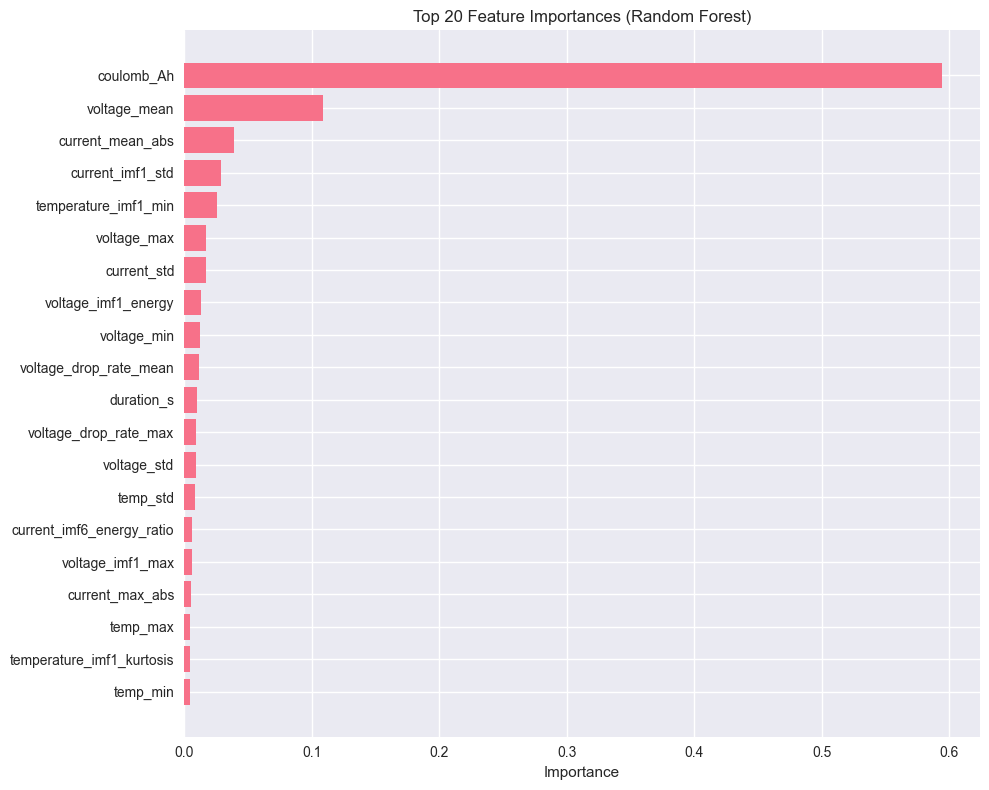

In [9]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_n = 20
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


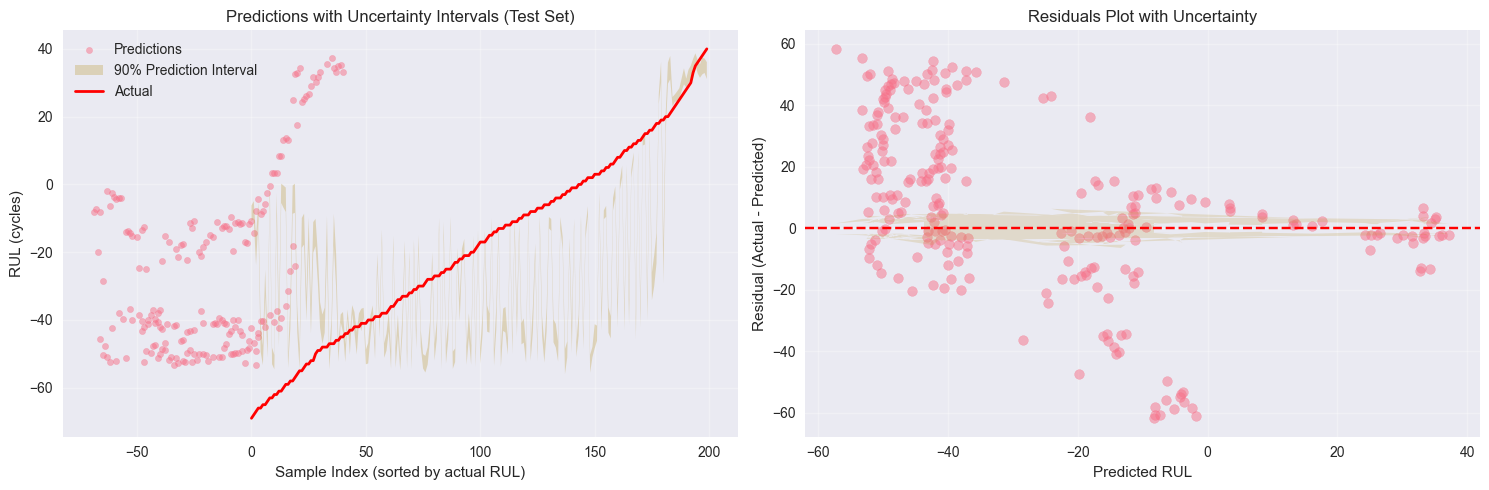

In [10]:
# Visualize predictions with uncertainty intervals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Predictions vs Actual with uncertainty
sample_idx = np.random.choice(len(y_test), min(200, len(y_test)), replace=False)
sorted_idx = np.argsort(y_test[sample_idx])

axes[0].scatter(y_test[sample_idx][sorted_idx], pred_median[sample_idx][sorted_idx], 
                alpha=0.5, s=20, label='Predictions')
axes[0].fill_between(range(len(sorted_idx)), 
                     pred_q05[sample_idx][sorted_idx],
                     pred_q95[sample_idx][sorted_idx],
                     alpha=0.3, label='90% Prediction Interval')
axes[0].plot(range(len(sorted_idx)), y_test[sample_idx][sorted_idx], 
             'r-', linewidth=2, label='Actual')
axes[0].set_xlabel('Sample Index (sorted by actual RUL)')
axes[0].set_ylabel('RUL (cycles)')
axes[0].set_title('Predictions with Uncertainty Intervals (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals plot
residuals = y_test - pred_median
axes[1].scatter(pred_median, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].fill_between(pred_median, 
                     pred_q05 - pred_median,
                     pred_q95 - pred_median,
                     alpha=0.2)
axes[1].set_xlabel('Predicted RUL')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].set_title('Residuals Plot with Uncertainty')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
# Save model and results
models_dir = project_root / "results" / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save the main model
model_path = models_dir / "random_forest_rul_model.pkl"
joblib.dump(rf_model, model_path)
print(f"✅ Saved model: {model_path}")

# Save predictions and uncertainty for later analysis
results = pd.DataFrame({
    'battery_id': df_clean.loc[test_idx, 'battery_id'].values,
    'cycle_index': df_clean.loc[test_idx, 'cycle_index'].values,
    'actual_rul': y_test,
    'predicted_rul': pred_median,
    'pred_q05': pred_q05,
    'pred_q25': pred_q25,
    'pred_q75': pred_q75,
    'pred_q95': pred_q95,
})

results_path = models_dir / "rf_predictions.csv"
results.to_csv(results_path, index=False)
print(f"✅ Saved predictions: {results_path}")

# Save metrics
metrics = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'R²', 'MAPE'],
    'train': [train_metrics['mae'], train_metrics['rmse'], train_metrics['r2'], train_metrics['mape']],
    'val': [val_metrics['mae'], val_metrics['rmse'], val_metrics['r2'], val_metrics['mape']],
    'test': [test_metrics_median['mae'], test_metrics_median['rmse'], 
             test_metrics_median['r2'], test_metrics_median['mape']]
})

metrics_path = models_dir / "rf_metrics.csv"
metrics.to_csv(metrics_path, index=False)
print(f"✅ Saved metrics: {metrics_path}")

print(f"\n📊 Summary:")
print(f"   Test MAE: {test_metrics_median['mae']:.2f} cycles")
print(f"   Test RMSE: {test_metrics_median['rmse']:.2f} cycles")
print(f"   Test R²: {test_metrics_median['r2']:.3f}")
print(f"   90% Coverage: {coverage_90*100:.1f}%")


✅ Saved model: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/random_forest_rul_model.pkl
✅ Saved predictions: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/rf_predictions.csv
✅ Saved metrics: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/rf_metrics.csv

📊 Summary:
   Test MAE: 21.08 cycles
   Test RMSE: 27.64 cycles
   Test R²: -0.036
   90% Coverage: 9.2%
